In [4]:
import pandas as pd
import numpy as np
import os
%run 'functions_dump.py'
% matplotlib inline

In [5]:
def find_folder_upstream(folder_name, max_iterations=50):
    current_folder = os.getcwd()
    counter = 0
    while os.path.basename(current_folder) != folder_name and counter < max_iterations:
        current_folder = os.path.dirname(current_folder)
        counter += 1
    if not counter < max_iterations:
        return None
    return current_folder

root_folder_name = 'HIS3InterspeciesEpistasis'
root_folder = find_folder_upstream(root_folder_name)
if not root_folder:
    print 'Did not find root folder for our github repository.\nPlease run "ks01" notebook from a script inside the HIS3InterspeciesEpistasis folder!'

data_folder = os.path.join(root_folder, 'Data', '')
small_tables_folder = os.path.join(root_folder, 'Data_Small_Tables', '')
analysis_folder = os.path.join(root_folder, 'Analysis', '')
karen_folder = os.path.join(analysis_folder, 'Karen', '')
figures_folder = os.path.join(karen_folder, 'figures', '')
files_dump_folder = os.path.join(karen_folder, 'files_dump', '')
structure_predictions_folder = os.path.join(files_dump_folder, 'structure_predictions', '')
structure_visualizations_folder = os.path.join(files_dump_folder, 'structure_visualizations', '')
pymol_sessions_folder = os.path.join(files_dump_folder, 'structure_visualizations/pymol_sessions/', '')

In [6]:
structural_data = pd.read_hdf(files_dump_folder + 'structural_data_for_predicted_24mer.hdf', 'data')

In [7]:
%run 'ks23_Read_Lucas_sign_epistasis_data.ipynb'

94 positions under sign epistasis
59 positions under reciprocal sign epistasis
Pandas DataFrames available:
lucas_sign_epistasis, lucas_reciprocal_sign_epistasis

pBon threshold = 0.01
The following sets of positions are available:
all_sampled_positions, sign_epistasis_positions, reciprocal_sign_epistasis_positions


In [8]:
def get_distance_from_structural_data_table(df):
    VarPos_absolute, SubPos_absolute = df[['VarPos_absolute', 'SubPos_absolute']]
    try:
        distance = structural_data.loc['res_%s' %VarPos_absolute]['res_%s' %SubPos_absolute]
        return distance
    except KeyError:
        return None

lucas_sign_epistasis['distance'] = lucas_sign_epistasis.apply(get_distance_from_structural_data_table, axis=1)
lucas_sign_epistasis[sign_cols + ['distance']][:2]

,VarPos_absolute,SubPos_absolute,pBon,logodds,distance
0,141,143,2.480092e-242,0.009042,4.477087
1,141,143,2.606182e-122,0.031833,4.477087


In [14]:
natasha_sign = pd.read_table(files_dump_folder + 'Distances_sign_epistasis_Natasha/' + 'False-True.allAtomCont.txt')
natasha_no_sign = pd.read_table(files_dump_folder + 'Distances_sign_epistasis_Natasha/' + 'pBon.allAtomCont.txt')

In [125]:
p_value_threshold = 0.01
lucas_sign = lucas_sign_epistasis[(lucas_sign_epistasis.pBon < p_value_threshold) & (lucas_sign_epistasis.logodds > 1)].dropna()
lucas_no_sign = lucas_sign_epistasis[(lucas_sign_epistasis.pBon > p_value_threshold) | (lucas_sign_epistasis.logodds < 1)].dropna()

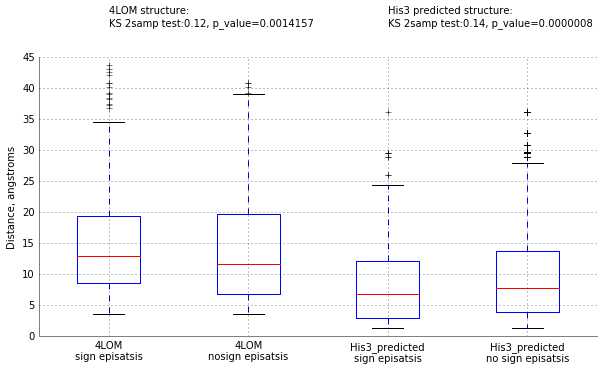

In [130]:
plot_better()
plt.boxplot([natasha_sign['distance_4LOM'], natasha_no_sign['distance_4LOM'], lucas_sign['distance'], lucas_no_sign['distance']]);
plt.ylabel('Distance, angstroms')
plt.xticks([1,2,3,4], ['4LOM\nsign episatsis', '4LOM\nnosign episatsis', 'His3_predicted\nsign episatsis', 'His3_predicted\nno sign episatsis'])
statistics_natasha = stats.ks_2samp(natasha_sign['distance_4LOM'], natasha_no_sign['distance_4LOM'])
statistics_karen = stats.ks_2samp(lucas_sign['distance'], lucas_no_sign['distance'])
plt.text(1, 50, "4LOM structure:\nKS 2samp test:%.2f, p_value=%.7f" %(statistics_natasha[0], statistics_natasha[1]))
plt.text(3, 50, "His3 predicted structure:\nKS 2samp test:%.2f, p_value=%.7f" %(statistics_karen[0], statistics_karen[1]))

In [67]:
lucas_sign_epistasis['position_pair'] = lucas_sign_epistasis.apply(lambda df: tuple(sorted((int(v) for v in df[['VarPos_absolute', 'SubPos_absolute']].values))), axis=1)

In [68]:
natasha_merged = natasha_sign.merge(natasha_no_sign, how='outer', on=['position1', 'position2', 'distance_4LOM'])
natasha_merged['position_pair'] = natasha_merged.apply(lambda df: tuple(sorted([int(v) for v in df[['position1', 'position2']].values])), axis=1)

In [69]:
nat_dist = pd.DataFrame(natasha_merged.groupby('position_pair')['distance_4LOM'].agg(np.mean))
karen_dist = pd.DataFrame(lucas_sign_epistasis.groupby('position_pair')['distance'].agg(np.mean))

In [89]:
not_in_Natasha = lucas_sign_epistasis[~lucas_sign_epistasis['position_pair'].isin(nat_dist.index)]
not_in_Natasha = pd.DataFrame(not_in_Natasha.groupby('position_pair')['distance'].agg(np.mean))

(0, 45)

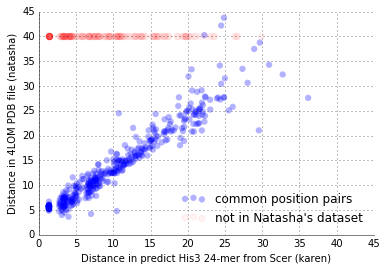

In [97]:
karen_natasha_dist = nat_dist.merge(karen_dist, left_index=True, right_index=True, how='inner')
plot_better(width=6, height=4)
plt.scatter(karen_natasha_dist['distance'], karen_natasha_dist['distance_4LOM'], edgecolor='none', s=40, alpha=0.3, label='common position pairs')
plt.scatter(not_in_Natasha['distance'], [40 for v in not_in_Natasha['distance']], color='red', s=40, alpha=0.05, label="not in Natasha's dataset")
plt.xlabel('Distance in predict His3 24-mer from Scer (karen)')
plt.ylabel('Distance in 4LOM PDB file (natasha)')
plt.legend(loc='lower right', frameon=False)
plt.xlim(0,45)
plt.ylim(0,45)